Import the libraries necessary to analize data

In [300]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [301]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          187534 non-null  float64
 1   incident_gravity           187534 non-null  float64
 2   females_rate               187534 non-null  float64
 3   minor_rate                 187534 non-null  float64
 4   arrested_rate              187534 non-null  float64
 5   survival_rate              187534 non-null  float64
 6   winning_party_percentage   187534 non-null  float64
 7   killed_rate                187534 non-null  float64
 8   injured_rate               187534 non-null  float64
 9   killed_disp_per_district   187534 non-null  float64
 10  injured_disp_per_district  187534 non-null  float64
 11  part_disp_per_district     187534 non-null  float64
 12  avg_age_participants       187534 non-null  float64
 13  n_participants             18

We selected one state as stated in subtask of clustering task.

In particular, we decided to select one of states with the highest number of gun incidents, in particular California

In [302]:
df['state'].value_counts()

state
illinois          15319
california        12980
florida           11972
texas             10453
new york           8449
ohio               8137
georgia            7300
pennsylvania       7142
north carolina     6874
louisiana          6345
tennessee          5931
missouri           5784
south carolina     5604
massachusetts      4969
virginia           4576
indiana            4560
michigan           4544
new jersey         4530
maryland           4266
alabama            4117
wisconsin          3969
kentucky           3260
oklahoma           2906
mississippi        2777
washington         2735
colorado           2654
connecticut        2599
arkansas           2337
iowa               2238
oregon             1884
arizona            1861
kansas             1829
minnesota          1715
nevada             1502
new mexico         1406
nebraska           1318
west virginia      1215
alaska             1215
utah                872
new hampshire       821
maine               802
rhode isla

In [303]:
df = df.loc[df['state'] == 'california']

In [304]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'involve_injury', 'involve_arrest','is_survived','pc1', 'pc2']

       
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'involve_killing',
 'involve_injury',
 'involve_arrest',
 'is_survived',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [305]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

To choose the best eps value we create the distance matrix 

In [306]:
dist = pdist(df_numeric, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

To choose the epsilon parameter, we will use the elbow method.

In [307]:
k = 10
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

Text(0.5, 0, 'sorted distances')

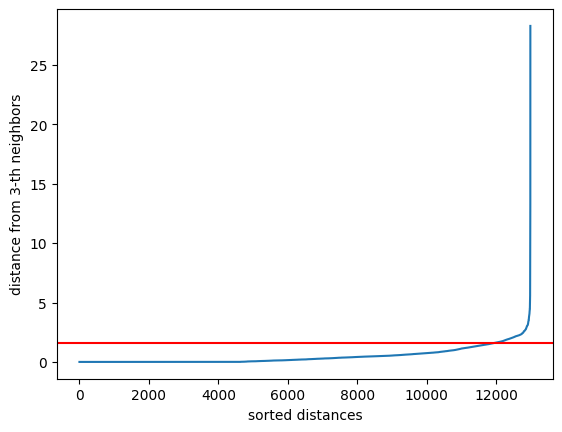

In [358]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y=1.6, color='r', linestyle='-')
plt.ylabel(f'distance from {k}-th neighbors')
plt.xlabel('sorted distances')

We can identify the Elbow in the value of 1.5, so this value is a candidate for the Epsilon.

In [359]:
#Coarse grain search for the number of min_samples
#min_samples = [20, 50, 150, 200]
#Finer grain search for the number of min_samples
min_samples = [160,170,180]

#Coarse grain search for the number of eps
#eps_l = [1.6, 1.7, 1.9, 2.0, 2.2, 2.3, 2.5]
#Finer grain search for the number of eps
eps_l = [1.6, 1.7]

In [360]:
from sklearn import metrics

table = []
for eps in eps_l:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(df_numeric)
        n_clusters = len(np.unique(dbscan.labels_))
        silhouette = metrics.silhouette_score(df_numeric, dbscan.labels_)
        DBscore = metrics.davies_bouldin_score(df_numeric, dbscan.labels_)
        table.append({"eps":eps, "silhouette": silhouette, "DBscore":DBscore, "n_clusters": n_clusters, "min_samples": min_sample})
        

In [361]:
pd.DataFrame(table).sort_values(by="silhouette", ascending=False)


,eps,silhouette,DBscore,n_clusters,min_samples
0,1.6,0.202494,2.001814,5,160
1,1.6,0.199733,2.004573,5,170
2,1.6,0.197965,1.998093,5,180
5,1.7,0.180224,2.643053,3,180
3,1.7,0.086065,2.570127,4,160
4,1.7,0.073308,2.567566,4,170


The best looking value of silhouette is the eps 1.6 with 160 samples.

Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

noise points: 3327


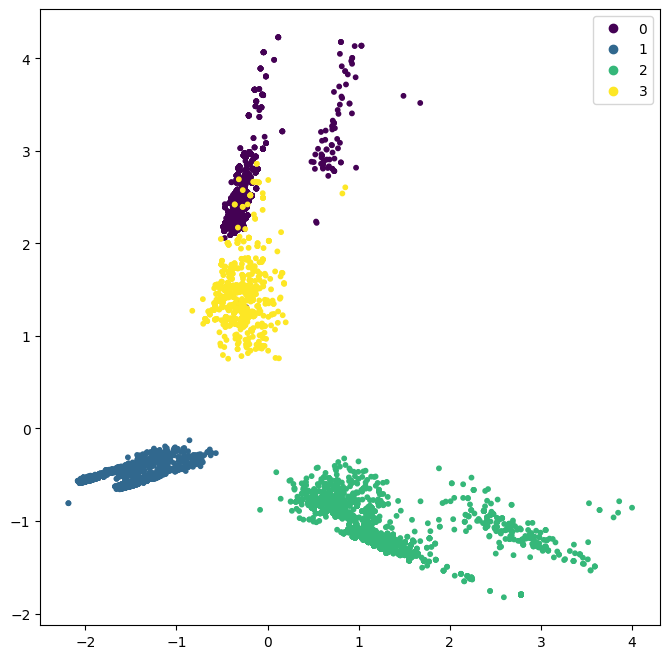

In [354]:
eps = 1.6
min_samples = 160
# Perform DB scan
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(df_numeric)
print(f"noise points: {(dbscan.labels_==-1).sum()}")

plt.figure(figsize=(8,8))
#printing the scatter without -1 labels (noise points)
scatter = plt.scatter(df['pc1'][dbscan.labels_!=-1], df['pc2'][dbscan.labels_!=-1], c=dbscan.labels_[dbscan.labels_!=-1], s=10)
#scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

In [322]:
#np.unique(dbscan.labels_, return_counts=True)

In [355]:
# Calculate number of clusters for final dbscan
n_clusters = len(np.unique(dbscan.labels_))-1

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(dbscan.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [1949, 4616, 2477, 611]


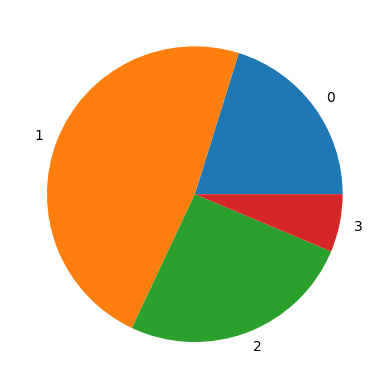

In [356]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

As we can see the number of killed persons in 1 out of 2 clusters is 0.

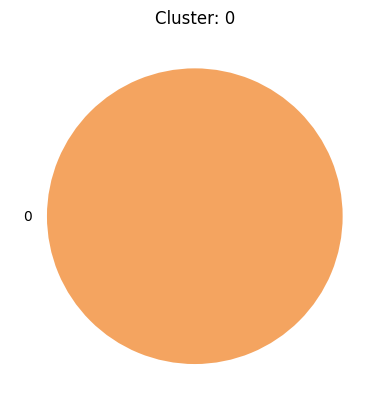

involve_injury
0    1949
Name: count, dtype: int64


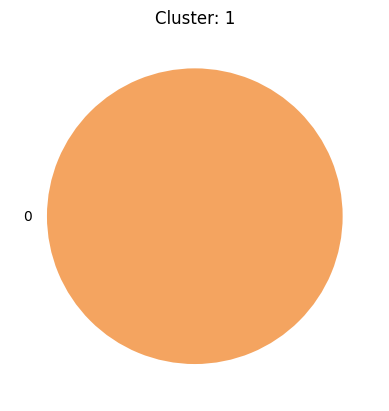

involve_injury
0    4616
Name: count, dtype: int64


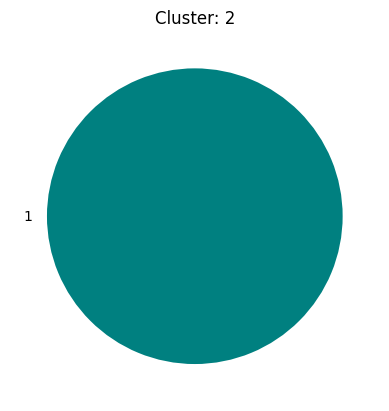

involve_injury
1    2477
Name: count, dtype: int64


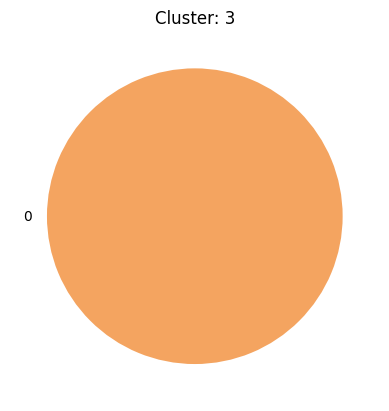

involve_injury
0    611
Name: count, dtype: int64


In [357]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_injury'].loc[dbscan.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

## Best clustering method
From our experiments we obtained the best performances from the DB_Scan Clustering, so we selected it as our final method by looking at the distribution of the clusters and to the distribution of incidents involving at least one death or no death in each cluster.